In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [ ]:
# 读取Excel数据
file_path = '/content/drive/MyDrive/reTesla chip/total_v0708.xlsx'  # 请替换为实际路径
data = pd.read_excel(file_path)

# 打印数据的行数和列数
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

# 显示数据的头三行
print("First three rows of data:")
print(data.head(3))

Number of rows: 9551
Number of columns: 10
First three rows of data:
   Cycle  Theta   R1   L1   LL1    P1    H1  Mixing Efficiency  \
0      1     20  0.1  0.7  0.05  0.15  0.05          29.586598   
1      1     20  0.1  0.7  0.05  0.15  0.10          51.676430   
2      1     20  0.1  0.7  0.05  0.15  0.15          52.700583   

                                            filename Unnamed: 9  
0  F:/comsol_0522_ncheng/image/u1_v/u1_angle20_40...        NaN  
1  F:/comsol_0522_ncheng/image/u1_v/u1_angle20_40...        NaN  
2  F:/comsol_0522_ncheng/image/u1_v/u1_angle20_40...        NaN  


Epoch 1/4000
478/478 [==============================] - 4s 7ms/step - loss: 867.9446 - val_loss: 501.7563
Epoch 2/4000
478/478 [==============================] - 3s 6ms/step - loss: 601.3162 - val_loss: 490.8105
Epoch 3/4000
478/478 [==============================] - 4s 9ms/step - loss: 569.9451 - val_loss: 530.6522
Epoch 4/4000
478/478 [==============================] - 4s 8ms/step - loss: 561.1360 - val_loss: 561.4346
Epoch 5/4000
478/478 [==============================] - 3s 6ms/step - loss: 542.3435 - val_loss: 493.3611
Epoch 6/4000
478/478 [==============================] - 3s 6ms/step - loss: 523.8921 - val_loss: 439.6956
Epoch 7/4000
478/478 [==============================] - 3s 6ms/step - loss: 510.0992 - val_loss: 459.2029
Epoch 8/4000
478/478 [==============================] - 5s 10ms/step - loss: 495.6616 - val_loss: 432.1686
Epoch 9/4000
478/478 [==============================] - 3s 6ms/step - loss: 483.3997 - val_loss: 432.7130
Epoch 10/4000
478/478 [======================

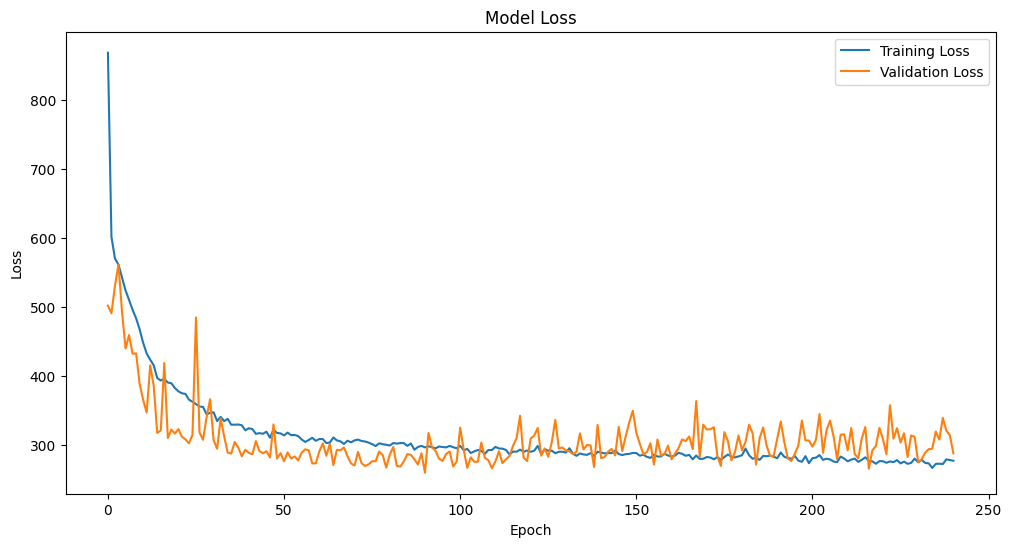

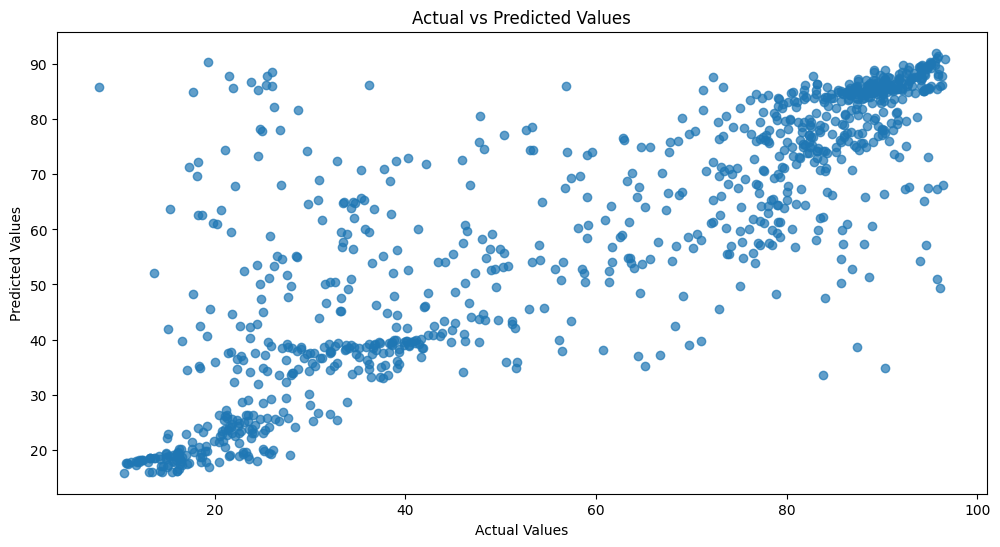

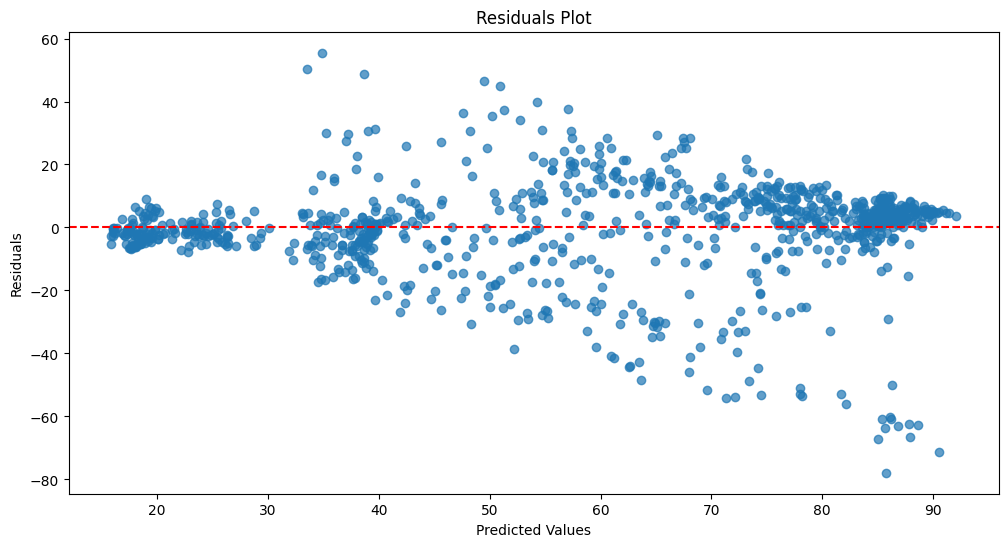

In [ ]:
# 分离输入特征和输出特征
X = data[['Cycle', 'Theta', 'R1', 'L1', 'LL1', 'P1', 'H1']].values
y = data['Mixing Efficiency'].values

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# 构建更深层次的全连接神经网络模型
model = Sequential()
model.add(Dense(512, input_dim=7, activation='relu'))  # 增加神经元数量和层数
model.add(Dropout(0.5))  # 增加Dropout率
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # 输出层改为1，因为只有一个输出特征

# 编译模型
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# 定义早停和模型检查点回调
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# 训练模型
epochs = 4000  # 增加训练周期数量
batch_size = 16  # 增加批量大小
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint], verbose=1)

# 在测试集上评估模型
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()  # 将二维数组转换为一维数组
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae}")
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")

# 绘制训练过程中的损失值
plt.figure(figsize=(12, 6))
if 'loss' in history.history and 'val_loss' in history.history:
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Error: 'loss' and 'val_loss' keys are not found in history.history")

# 确保 y_test 和 y_pred 形状相同
y_test = np.array(y_test)

if y_test.shape[0] != y_pred.shape[0]:
    raise ValueError(f"y_test and y_pred must have the same size, but got {y_test.shape[0]} and {y_pred.shape[0]} respectively.")

# 绘制实际值与预测值的散点图
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# 绘制残差图
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# 获取当前日期并格式化
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

directory = os.path.dirname(file_path)

model_file = os.path.join(directory, f"trained_model_{current_date}.keras")
# 保存模型文件名
model.save(model_file)

# 创建评估结果 DataFrame
results = pd.DataFrame({
    'Metric': ['MAE', 'R-squared', 'RMSE'],
    'Value': [mae, r2, rmse]
})

# 构建评估结果文件的完整路径
results_file = os.path.join(directory, 'model_evaluation_results.xlsx')
# 将评估结果保存到 Excel 表格
results.to_excel(results_file, index=False)